In [1]:
import os
import numpy as np
from numpy import array
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from mockfactory import Catalog
from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import KaiserTracerPowerSpectrumMultipoles, TNSTracerPowerSpectrumMultipoles, FOLPSTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.samples import Profiles
from desilike import setup_logging
setup_logging()  # for logging messages

[Macpomme.local:30623] shmem: mmap: an error occurred while determining whether or not /var/folders/n0/gs1g7p590qg7trf8pp8w29ch0000gn/T//ompi.Macpomme.501/jf.0/2813526016/sm_segment.Macpomme.501.a7b30000.0 could be created.


In [2]:
kmin     = 0.008
kmax     = 0.2
binning  = 0.006
k_ev     = np.arange(kmin, kmax+0.001, binning)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

# the cosmology parameters
catalogue   = 'fiducial'  # fiducial, Mnu_p, Mnu_ppp -- QUIJOTE catalogue
cosmology   = 'LCDM'  # LCDM, nuCDM, nsFree, wCDM -- cosmology model
r_pk        = 'RSD'  # RSD, LRG, QSQ, CATAS-- systematics
CovRsf      = 25  # -- covariance rescale factor

In [3]:
def dataload(data):
    Pk0 = [[],[]]
    Pk2 = [[],[]]
    k = data[0,:,1]
    l0 = data[:,:,3]
    l2 = data[:,:,4]
    Pk0[0] = np.mean(l0,axis=0)
    Pk0[1] = np.std(l0,axis=0)
    Pk2[0] = np.mean(l2,axis=0)
    Pk2[1] = np.std(l2,axis=0)
    pk_cov = np.append(l0,l2,axis=1)
    cov = np.cov(np.array(pk_cov).T)
    # icov = np.linalg.inv(cov)
    return (k,Pk0,Pk2, cov)

def Pkload(catalogue, r_pk, redshift):
    # load the QUIJOTE observation
    tool = 'Pypower' # Powspec, Pypower, NCV
    Ddir = f'/Users/alain/Desktop/projectNU/main/data/kbin2/{catalogue}/{r_pk}_z{redshift}/pk'
    data = []
    nb = np.arange(100,200,1)
    for h in nb:
        realisation=np.loadtxt(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
        data.append(realisation)
    print(Ddir+f'/{catalogue}_{h}_z{redshift}.pk')
    (kev, pk0, pk2, icov) = dataload(np.array(data))
    pkl = [kev, pk0, pk2, icov]
    return pkl


[000228.54] [0/1] 06-28 11:15  Emulator                  INFO     Loading ./model/emulator_Kaiser_z0.5.npy.
[000229.00] [0/1] 06-28 11:15  Profiles                  INFO     Loading ./profiler_result/profile_Kaiser_z0.5.npy.
[000229.02] [0/1] 06-28 11:15  Emulator                  INFO     Loading ./model/emulator_TNS_z0.5.npy.
[000229.85] [0/1] 06-28 11:15  Profiles                  INFO     Loading ./profiler_result/profile_TNS_z0.5.npy.
[000229.87] [0/1] 06-28 11:15  Emulator                  INFO     Loading ./model/emulator_FOLPS_z0.5.npy.
[000230.31] [0/1] 06-28 11:15  Profiles                  INFO     Loading ./profiler_result/profile_FOLPS_z0.5.npy.
/Users/alain/Desktop/projectNU/main/data/kbin2/fiducial/RSD_z0.5/pk/fiducial_199_z0.5.pk
[000230.42] [0/1] 06-28 11:15  Emulator                  INFO     Loading ./model/emulator_Kaiser_z1.0.npy.
[000230.71] [0/1] 06-28 11:15  Profiles                  INFO     Loading ./profiler_result/profile_Kaiser_z1.0.npy.
[000230.73] [0/1] 0

Text(0.81, 0.8, '$z=1.0 $')

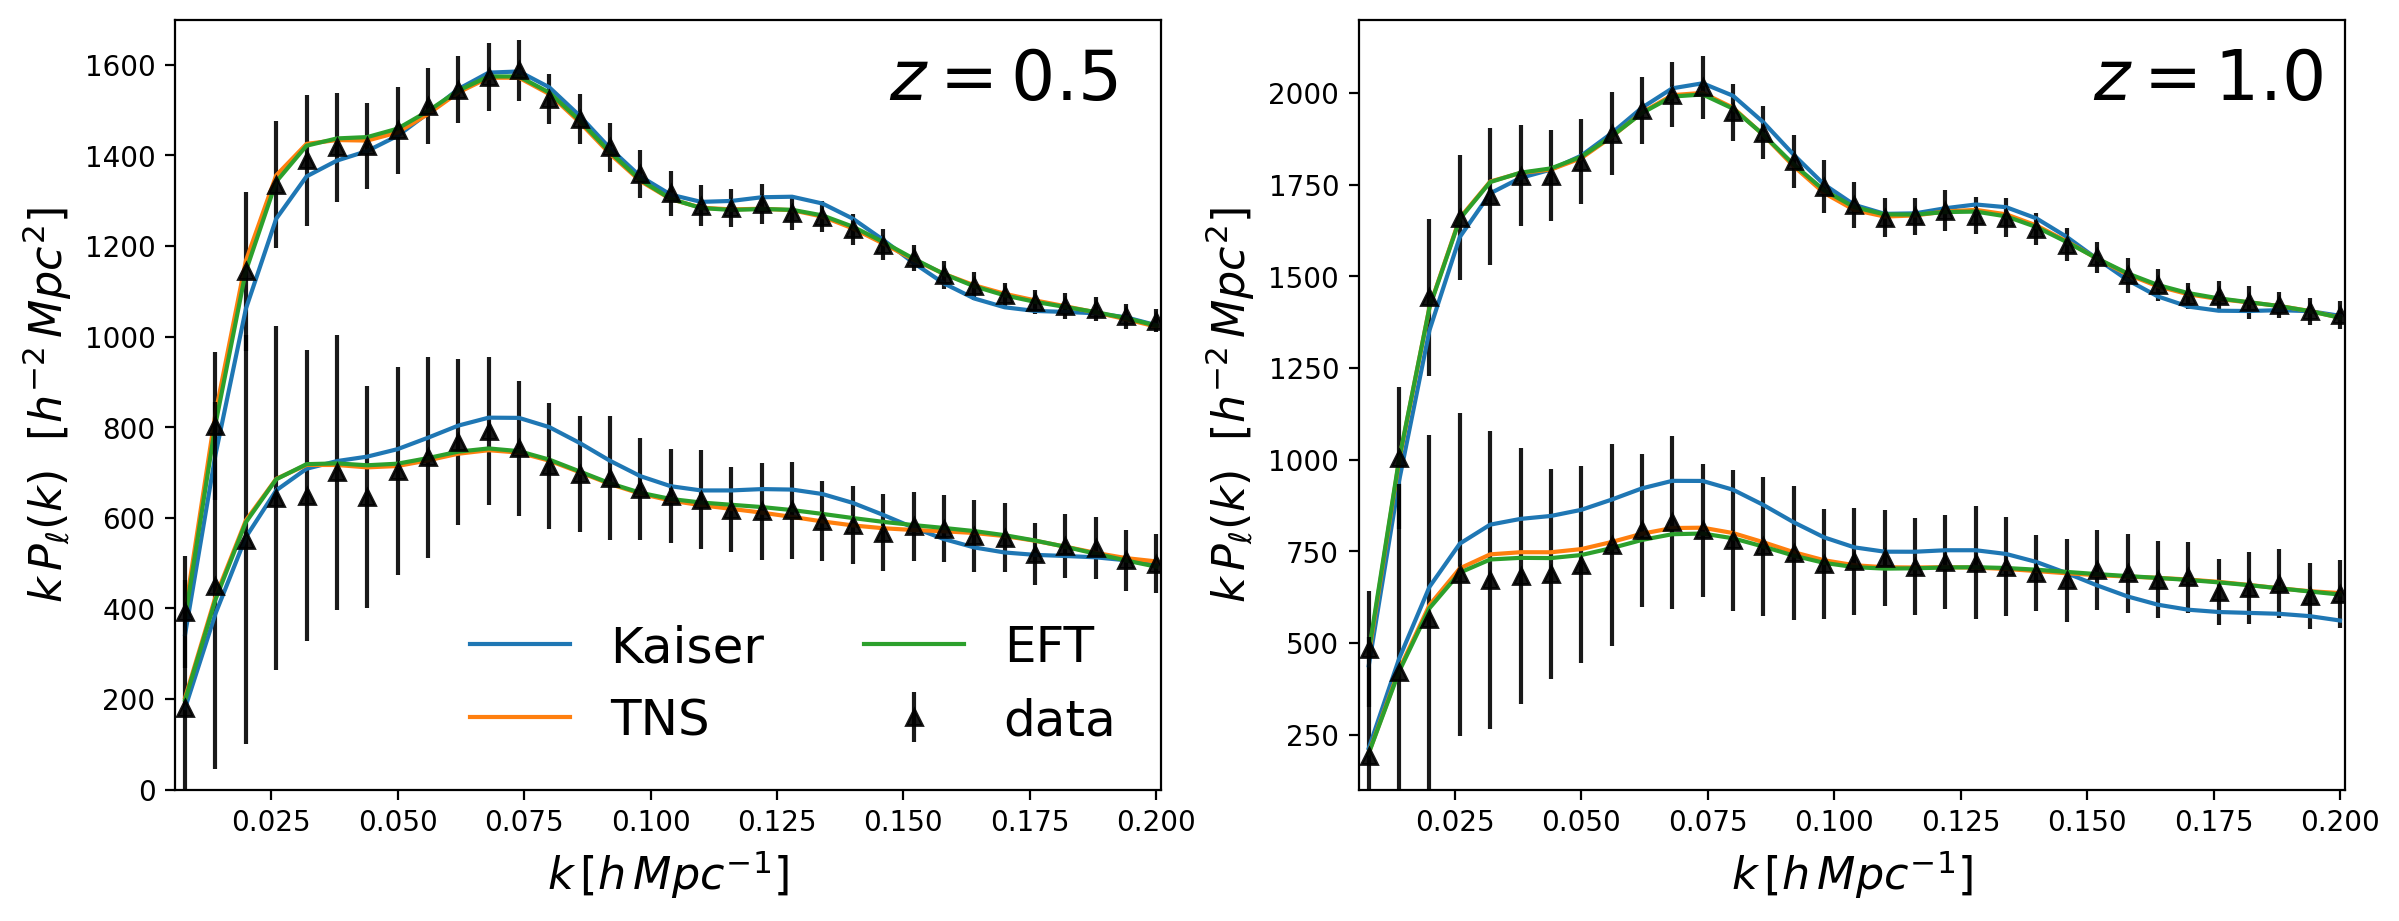

In [8]:
models = ['Kaiser', 'TNS', 'FOLPS']
labels = [r'Kaiser', r'TNS', r'EFT']
colors = ['C0','C1','C2']

fig, axs = plt.subplots(1, 2, figsize = (14, 5),sharex=True)
for i,redshift in enumerate([0.5,1.0]):
    Pkmodel = []
    for model in models:
        emulator_fn = f'./model/emulator_{model}_z{redshift}.npy'
        profile_fn = f'./profiler_result/profile_{model}_z{redshift}.npy'
        if model == 'Kaiser':
            theory = KaiserTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        elif model == 'TNS':
            theory = TNSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        elif model == 'FOLPS':
            theory = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn))
        profile = Profiles.load(profile_fn)
        # print(profile.to_stats(tablefmt='pretty'))
        pkl = theory(**profile.bestfit.choice(input=True))
        Pkmodel.append(pkl)
    [k_ev, pk0, pk2, cov] = Pkload('fiducial', 'RSD', redshift)
    Pkobs = [pk0,pk2]
    for ell, l in zip(['monopole','quadrupole'],range(2)):
        axs[i].errorbar(k_ev, k_ev*Pkobs[l][0], k_ev*Pkobs[l][1], color='black', alpha=0.9, fmt='^', label='data')
        # axs[i].fill_between(k_ev, k_ev*(Pkobs[l][0]+Pkobs[l][1]), k_ev*(Pkobs[l][0]-Pkobs[l][1]), color='grey', alpha=0.5)
        for t in range(len(models)):
            axs[i].plot(k_ev, k_ev*Pkmodel[t][l], color = colors[t], label = f"{labels[t]}")
        if i ==0 and l==0:
            leg2 = axs[0].legend(loc =4, fontsize =  18, ncol=2)
            leg2.get_frame().set_linewidth(0.0)
    axs[i].set_xlabel(r'$k \, [h\, Mpc^{-1}]$', fontsize =  16)
    axs[i].set_ylabel(r'$k \, P_{\ell}(k)$  $[h^{-2} \, Mpc^{2}]$', fontsize =  16)
    plt.xlim([0.006, 0.201])
    if i == 0:
        axs[i].set_ylim([0, 1700])
    if i == 1:
        axs[i].set_ylim([100, 2200])

plt.figtext(0.38, 0.8, r'$z=0.5 $', fontsize=25)
plt.figtext(0.81, 0.8, r'$z=1.0 $', fontsize=25)